# Final Project B

## Basic stats. Let's understand the dataset better
We start of by cleaning and preparing our data which consists of over 1.67M rows with a total of 29 columns.


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import datetime as dt
df_crash = pd.read_csv("C:\\Users\Rimmen\Downloads\data\Motor_Vehicle_Collisions_-_Crashes.csv", low_memory = False)
#print(df_crash.shape)
#df_crash.head(5)
df_crash["CRASH DATE"] = df_crash["CRASH DATE"].apply(lambda x: datetime.strptime(x, "%m/%d/%Y") )
df_crash["CRASH TIME"] = df_crash["CRASH TIME"].apply(lambda x: datetime.strptime(x, "%H:%M") )

### Time-series
As we're dealing with data that ranges from mid 2012 to now, we want to make sure that there aren't any missing gaps throughout this period of time.

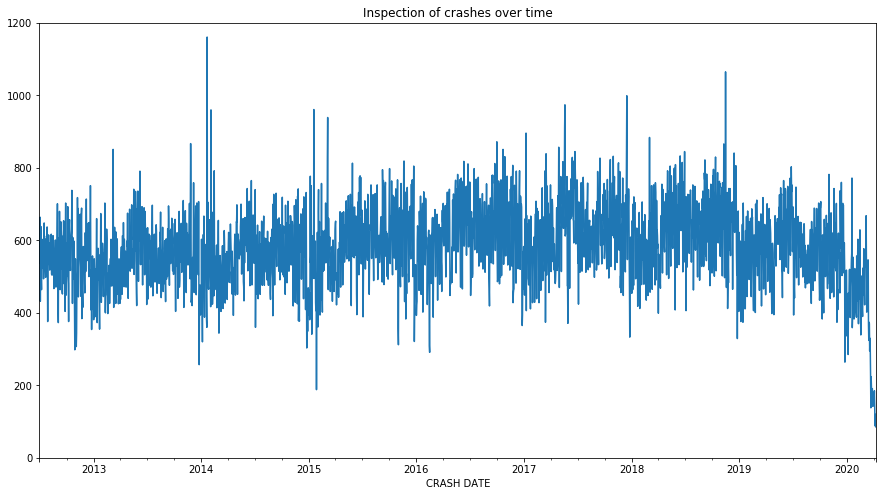

In [16]:
#Checking the range of our data
df_crash.groupby('CRASH DATE').size().plot(figsize=(15,8),ylim = (0,1200), title = "Inspection of crashes over time" )

There appear to be no gaps (missing periods) from mid 2012 to 2020. But since we will be taking a look at the change of crashed from year to year, we will limit our data to consist of only dates ranging from 2013 to 2019. 

In [19]:
df_crash = df_crash.loc[((df_crash['CRASH DATE'].dt.year !=2020) & (df_crash['CRASH DATE'].dt.year != 2012))]

## Filling out missing values

A large part of our data was missing information about the borough the crash took place in. This information is however obtainable by looking up the coordinates, if given. To do this, we made use of the package 'geopy' and withdrew as many zip codes as we could, followed by merging thems with a list of which zip codes belonged to which borough in New York City.

Almost 320,000 rows were missing information about the Borough, while both latitude and longitude were present.

In [21]:
df_crash.loc[(df_crash['BOROUGH'].isna() & (df_crash['LATITUDE'].notna() & df_crash['LONGITUDE'].notna()))].shape

(318827, 29)

**Warning**! The following code is looking up each unique pair of coordinates and takes approximately 6 hours.

In [35]:
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt

df_latlong = df_crash.loc[(df_crash['LATITUDE'].notna() & df_crash['LONGITUDE'].notna())].copy()
df_latlong['latlong'] = list(zip(df_latlong['LATITUDE'],df_latlong['LONGITUDE']))
locator = Nominatim(user_agent='myGeocoder', timeout= 50000)
dict_geocode = {}
address = df_latlong['latlong'].unique()
for x in address:
    if x not in dict_geocode:
        dict_geocode[x] = []
    location = locator.reverse(x)
    if 'address' in location.raw:
        if 'postcode' in location.raw['address']:
            dict_geocode[x].append(location.raw['address']['postcode'])

df_crash['address'] = list(zip(df_crash['LATITUDE'],df_crash['LONGITUDE']))
df_crash['postcode'] = df_crash['address'].map(dict_geocode)

df_zipcode = pd.read_csv("C:\\Users\Dude\Desktop\zip_codes2.csv")
df_zipcode['postcode'] = df_zipcode['postcode'].astype('str')

dict_zipcode = df_zipcode.set_index('postcode')['borough']
df_crash['district']=df_crash['postcode'].map(dict_zipcode)
df_crash['district']=df_crash['district'].str.upper()

#Replacing missing values in 'Borough' with the ones we've just retrived.
df_crash['BOROUGH'].loc[(df_crash['BOROUGH'].isna() & df_crash['district'].notna())] = df_crash['district']

#Saving our new dataset - to prevent running above code again.
df_crash.to_csv(r'C:\\Users\Dude\Desktop\crash_data.csv', index=False)

In [18]:
# We then have our new dataset - which we load again to prevent running above code
df_crash = pd.read_csv("C:\\Users\Rimmen\Downloads\Data\crash_data.csv",low_memory=False)
df_crash["CRASH DATE"] = df_crash["CRASH DATE"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
df_crash["CRASH TIME"] = df_crash["CRASH TIME"].apply(lambda x: datetime.strptime(x, "%H:%M:%S"))

We ended up fill out over 300,000 missing values for borough.

In [3]:
df_crash.loc[(df_crash['BOROUGH'].isna() & (df_crash['LATITUDE'].notna() & df_crash['LONGITUDE'].notna()))].shape

(4904, 29)

## Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.

- Await exploratory analysis


## If relevant, talk about your machine-learning

Through machine learning, we wanted to see if the implmentation of different initiatives would have any impact on the contributing factors of a crash. However, the implementations for Vision Zero are plenty, and it would be hard to distinguish one from another. We therefore chose to single out an initiative, that we believe would have an high impact on certain contributing factors for a crash. Reduction of speed. 

In the late 2014, New York City reduced the default speed limit to 25 MPH, and installed multiple speed cameras and speed bumps. ([Automated Speed Enforcement Program Report, 2014-2017](http://www.nyc.gov/html/dot/downloads/pdf/speed-camera-report-june2018.pdf)) We believe that the reduction of speed would have a high impact on crashes caused by a slippery pavement, while crashes caused by alcohol involvement would be unaffected. 

By using the Random Forest Classifier model, we want to classify the contributing factor of a crash, given a time (hour), location (borough) and information on whether the 'reduction of speed' had taken place or not.
